In [64]:
from endurance.module import LinearLayer, Module
from endurance.variable import Variable
from endurance.activations import relu

from typing import Union

from sklearn.datasets import make_moons

import seaborn as sns

from matplotlib import pyplot as plt

import numpy as np

In [2]:
class ReLULayer(Module):
    def compute(self, x):
        return relu(x)
    
    def parameters(self):
        return []



class MyNeuralNetwork(Module):
    def __init__(self):
        self.layers = [LinearLayer(2, 16), ReLULayer(), LinearLayer(16, 1)]
        

    def compute(self, x: Union[Variable, list[Variable]]) -> Union[Variable, list[Variable]]:
        out = x
        for layer in self.layers:
            out = layer(out)

        return out


    def parameters(self) -> list[Variable]:
        return [p for layer in self.layers for p in layer.parameters()]


In [123]:
dataset = make_moons(n_samples=100, noise=0.15)
dataset = {"x" : dataset[0], "x0" : dataset[0][:, 0], "x1" : dataset[0][:, 1] , "y" : dataset[1]}

dataset["y"] = dataset["y"] * 2 - 1 #for the hinge loss 

<AxesSubplot:xlabel='x0', ylabel='x1'>

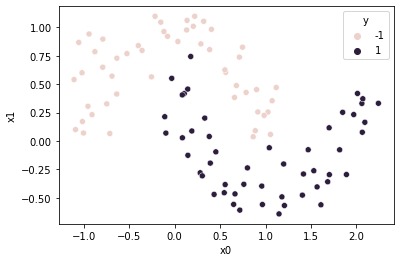

In [124]:
sns.scatterplot(data=dataset, x="x0", y="x1", hue="y")

In [125]:
#y = -1 or y = 1
def hinge_loss(pred, y):
    return relu(1 - pred * y)

#compute the loss for every data in the dataset, sum and divide for the len
def loss(model, ds):
    X, y = ds["x"], ds["y"]

    #loss on dataset
    predictions = list(map(network, X))
    l = sum([hinge_loss(pred, true_value) for pred, true_value in zip(predictions, y)])
    l /= len(predictions)

    #l2 reg (without this the model learns pretty bad)
    a = 1e-4
    l2_reg_loss = a * sum(p.value ** 2 for p in model.parameters()) 

    l += l2_reg_loss

    accuracy = sum([(pred.value > 0) == (true_value > 0) for pred, true_value in zip(predictions, y)]) / len(predictions)

    return l, accuracy

In [129]:
network = MyNeuralNetwork()
num_of_epochs = 50

initial_lr = 0.1
decay_rate = 0.001
lr = initial_lr

for epoch in range(num_of_epochs):
    #forward pass
    l, accuracy = loss(network, dataset)

    #backward pass
    network.zero_gradient()
    l.backward()

    #sgd step
    # lr = initial_lr / (1 + decay_rate * epoch)
    lr = 1.0 - 0.9*epoch/100
    for p in network.parameters():
        p.value = p.value - lr * p.gradient


    print(f"Epoch {epoch}   Loss {l.value}   Accuracy {accuracy}")

Epoch 0   Loss 0.39922368598919644   Accuracy 0.84
Epoch 1   Loss 0.44353482228605184   Accuracy 0.81
Epoch 2   Loss 0.3317850455013955   Accuracy 0.83
Epoch 3   Loss 0.32580160035818895   Accuracy 0.87
Epoch 4   Loss 0.33582761354449137   Accuracy 0.83
Epoch 5   Loss 0.2987193876812585   Accuracy 0.87
Epoch 6   Loss 0.31528355644858214   Accuracy 0.86
Epoch 7   Loss 0.29429653014216695   Accuracy 0.86
Epoch 8   Loss 0.30240958412110125   Accuracy 0.87
Epoch 9   Loss 0.2870649848280235   Accuracy 0.86
Epoch 10   Loss 0.3112486302934052   Accuracy 0.86
Epoch 11   Loss 0.2727632473936312   Accuracy 0.87
Epoch 12   Loss 0.27616146799756414   Accuracy 0.86
Epoch 13   Loss 0.27790312863233163   Accuracy 0.88
Epoch 14   Loss 0.29084816405703834   Accuracy 0.87
Epoch 15   Loss 0.26149060847183225   Accuracy 0.89
Epoch 16   Loss 0.26652290241991017   Accuracy 0.87
Epoch 17   Loss 0.2534747874892666   Accuracy 0.89
Epoch 18   Loss 0.25113176042353874   Accuracy 0.88
Epoch 19   Loss 0.2570461135

(-1.6416046821460504, 1.9583953178539488)

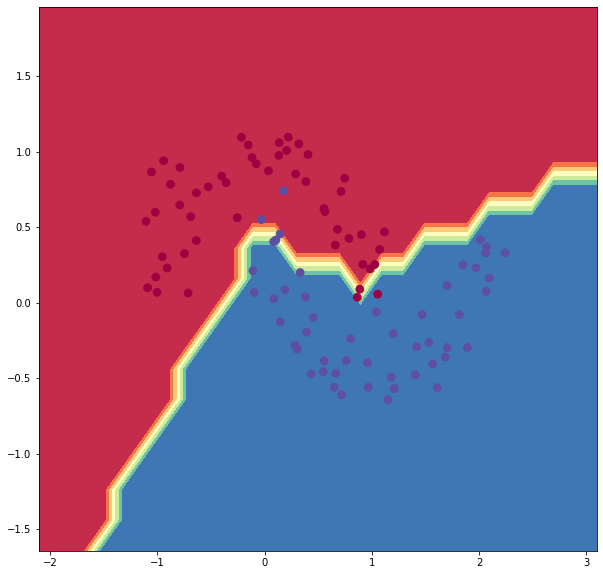

In [130]:
#https://hackernoon.com/how-to-plot-a-decision-boundary-for-machine-learning-algorithms-in-python-3o1n3w07
#https://stackoverflow.com/questions/22294241/plotting-a-decision-boundary-separating-2-classes-using-matplotlibs-pyplot
#plot decision boundary

X, y = dataset["x"], dataset["y"]

res = 0.2

min0, max0 = X[:, 0].min() -1, X[:, 0].max() + 1 
min1, max1 = X[:, 1].min() -1, X[:, 1].max() + 1 

x0grid = np.arange(min0, max0, res)
x1grid = np.arange(min1, max1, res)

xx, yy = np.meshgrid(x0grid, x1grid)

r1, r2 = xx.flatten(), yy.flatten()
r1 = np.reshape(r1, (len(r1), 1))
r2 = np.reshape(r2, (len(r2), 1))

grid = np.hstack((r1, r2))

predictions = list(map(network, grid))

zz = np.array([p.value > 0 for p in predictions])
zz = np.reshape(zz, xx.shape)


f = plt.figure(1, (10, 10))
plt.contourf(xx, yy, zz, cmap=plt.cm.Spectral)
plt.scatter(X[:, 0], X[:, 1], c=y, s=60, cmap=plt.cm.Spectral)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())